# Analysis of Select Chronic Diseases and Air Quality

---
**Data 102 Final Project**

**Contributors:** Janise Liang, Eduardo Madrigal, Sheryl Muttath, Nandita Radhakrishnan

In [1]:
# Uncomment and run this cell if using Colab
# from google.colab import drive
# import os

# drive.mount('/content/drive', force_remount=True)
# os.chdir('/content/drive/MyDrive/data102') # path to project directory

# Setup

## Dependencies

In [ ]:
# install all required packages
!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from scipy import stats
import re

from  tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sodapy import Socrata

In [4]:
import os

# we store preprocessed data as csv's in a folder called data
if not os.path.exists("data"):
    print("Created data directory")
    os.mkdir("data/")

# we store output figures as png's in the figures directory 
if not os.path.exists("figures"):
    print("Created figures directory")
    os.mkdir("figures/")

In [5]:
# seed for random sampling to guarantee reproducible output
np.random.seed(123)

# Preprocessing

**For Air Quality Data:**

Since we are trying see the effects of ozone and PM 2.5 concentration on chronic diseases, we are worried more about extended air quality patterns, rather than specific years of data. It is much more likely that chronic diseases will stem from extended exposure to air pollutants, rather than a small time period. We take the average over all the data available (January 2011 to December 2014), which assumes that this period is at least relatively representative of the long-term patterns before 2011.

**For Population Data:**

We load data from the US Census website and consolidate the population estimates into subgroups.

**For CDC Chronic Disease Indicators:**

Downloads and stores CDI dataset in data folder.

**For Other Data:**

Some preprocessing steps (for Diabetes Prevalence by Age/Sex) were not included in this notebook for brevity. The preprocessed file result is included in the data folder, and code to produce the data is also included.

## Helper Functions

In [6]:
def update_cdc_fips(fips):
    """ Updates (in-place) FIPS codes for CDC dataset to match wikipedia FIPS data """
    
    # County code changes in the 2010s - wikipedia is up-to-date but CDC slightly out of date
    fips_updates = {
    '46113': '46102', # shannon county, SD (46113) renamed to oglala lakota county (46102)
    '51515': '51019' # bedford city (51515) merged into bedford county (51019)
    }
    
    for oldfips, newfips in fips_updates.items():
        fips = fips.str.replace(oldfips, newfips, regex=False)
    return fips

def get_cdc_data(date, ozone=True, limit=100000):
    """
    Fetches data from CDC website using Socrata API.
    API code example from https://dev.socrata.com/foundry/data.cdc.gov/fcqm-xrf4

    DATE: array of strings in DDMMMYYYY form (e.g. "01JAN2014")
    OZONE: boolean (True for ozone data, False for PM 2.5 data)
    LIMIT: integer limit for maximum number of rows downloaded

    returns pandas dataframe containing up to LIMIT rows of the result
    """
    assert type(date) in [str, list]
    if type(date) == str:
        date = [date]
    
    dataset_id = "372p-dx3h" if ozone else "fcqm-xrf4"
    colname = "ds_o3_pred" if ozone else "ds_pm_pred"
    client = Socrata("data.cdc.gov", None)

    res = None
    for d in tqdm(date):
        # arguments are SQL-style: see https://dev.socrata.com/docs/queries/
        results = client.get(dataset_id, query=f"SELECT countyfips, {colname} WHERE date = '{d}' LIMIT {limit}")
        df = pd.DataFrame.from_records(results)
        df = df.rename(columns={colname: d})
        
        # since we only have population data at the county level and not city,
        # we aggregate to use the median of all cities in the same county
        df = df.groupby("countyfips").agg({d: 'median'})

        if res is None:
            res = df
        else:
            res = res.join(df, how='inner')

    # convert FIPS to 5-digit strings (so 1001 becomes '01001')
    res.index = res.index.astype(str).str.zfill(5)
    res.index = update_cdc_fips(res.index)
    return res

def get_county_fips(fips_path="data/county_to_state_aggregation/county_fips_wikipedia.csv"):
    """
    Parses wikipedia data downloaded from https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county
    CSV_PATH should be the path to the downloaded file
    """
    
    county_fips = pd.read_csv(fips_path, names=['fips', 'county', 'state'], header=0)
    
    # convert FIPS to 5-digit strings, and append state name to county
    county_fips['fips'] = county_fips['fips'].astype(str).str.zfill(5)
    county_fips['county'] = county_fips['county'] + ', ' + county_fips['state']
    county_fips['county'] = county_fips['county'].str.lower()

    # remove/replace special characters
    county_fips['county'] = county_fips['county'].str.replace("\s*–\s*", "-", regex=True)
    county_fips['state'] = county_fips['state'].str.replace("Hawaiʻi", "Hawaii", regex=False)

    # Replace phrases in wikipedia FIPS data to match with population dataset
    wiki_fips_replacements = {
        ", municipality of": " municipality",
        ", city and borough of": " city and borough",
        ", city of": " city",
        ", city and county of": " county",
        ", town and county of": " county",
        "city, consolidated municipality of": "city",
        "hawaiʻi": "hawaii"
    }

    for old, new in wiki_fips_replacements.items(): 
        county_fips['county'] = county_fips['county'].str.replace(old, new, regex=False)

    # valdez-cordova was split into chugach census area and copper river census area in 2019,
    # according to https://en.wikipedia.org/wiki/Valdez-Cordova_Census_Area
    # but the census data still uses the combined area
    county_fips.loc[len(county_fips)] = ['02063,02066', 'valdez-cordova census area, alaska', 'Alaska']
    
    return county_fips

def get_county_pops(pop_path="data/county_to_state_aggregation/county_populations.csv"):
    """
    Parses csv data downloaded from https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx
    CSV_PATH should be the path to the downloaded file
    """

    county_pops = pd.read_csv(pop_path, header=3)
    county_pops = county_pops[["Unnamed: 0", "2014"]].iloc[1:-6].rename(columns={"Unnamed: 0": "county", "2014": "2014 population"})

    # delete the dot in front of county names
    county_pops['county'] = county_pops['county'].str.lower().str.replace("^\.", "", regex=True)

    # convert string population numbers to int
    county_pops['2014 population'] = county_pops['2014 population'].str.replace(",", "").astype(int)

    return county_pops

def add_state_abbreviations(df, abbrev_path="data/county_to_state_aggregation/state_abbreviations.csv"):
    """
    Adds 2-letter state abbreviations to data frame based on table from
    https://www.scouting.org/resources/los/states/
    """
    
    abbrevs = pd.read_csv(abbrev_path, header=0, names=['state', 'abbrev'])
    df = df.merge(abbrevs, left_index=True, right_on="state", how="left")
    return df

def agg_county_weighted_mean(df, columns=None):
    """
    COLUMNS: 
    """
    if columns is None:
        columns = df.columns

    fip_to_county = get_county_fips()
    county_pops = get_county_pops()

    df = df.merge(fip_to_county, left_index=True, right_on="fips", how="left")
    df = df.merge(county_pops, on="county", how="left")

    # take weighted mean by county population
    wm = lambda x: np.average(x, weights=df.loc[x.index, "2014 population"])
    fn_mapper = {}
    for col in columns:
        fn_mapper[col] = (col, wm)
    df_by_state = df.groupby("state").agg(**fn_mapper)
    
    return add_state_abbreviations(df_by_state)

## Ozone Data Aggregation

Downloads data from the CDC's [Daily Census Tract-Level Ozone Concentrations](https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-Ozone-Concentrations-2011/372p-dx3h) and aggregates county-level data to state-level using a weighted mean based on county's population. We do this for the first day of every month from January 2011 to December 2014, then take the mean over all of these to calculate the average ozone concentration for the 4 years.

The resulting DataFrame is saved as a csv file at `data/average_ozone_per_state.csv`

In [7]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
dates = sum([["01"+m+str(yr) for m in months] for yr in np.arange(2011, 2015)], [])
ozone = get_cdc_data(dates, ozone=True)

  0%|          | 0/48 [00:00<?, ?it/s]

In [8]:
ozone_by_state = agg_county_weighted_mean(ozone)
ozone_by_state = ozone_by_state.set_index('abbrev')

In [9]:
ozone_by_state['average o3'] = ozone_by_state.drop(columns='state').mean(axis=1)
ozone_by_state['median o3'] = ozone_by_state.drop(columns=['state', 'average o3']).median(axis=1)
ozone_by_state = ozone_by_state[['state', 'average o3', 'median o3']]
ozone_by_state.to_csv("data/average_ozone_by_state.csv")

## PM 2.5 Data Aggregation

Downloads data from the CDC's [Daily Census Tract-Level PM2.5 Concentrations](https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2011/fcqm-xrf4) and aggregates county-level data to state-level using a weighted mean based on county's population. We do this for the first day of every month from January 2011 to December 2014, then take the mean over all of these to calculate the average ozone concentration for the 4 years.

The resulting DataFrame is saved as a csv file at `data/average_pm_by_state.csv`

In [10]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
dates = sum([["01"+m+str(yr) for m in months] for yr in np.arange(2011, 2015)], [])
pm25 = get_cdc_data(dates, ozone=False)

  0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
pm25_by_state = agg_county_weighted_mean(pm25)
pm25_by_state = pm25_by_state.set_index('abbrev')

In [12]:
yearly = {}
for i in range(4):
    yearly[f'{2011+i}'] = pm25_by_state.iloc[:, (i*12):((i+1)*12)].mean(axis=1)
yearly_pm25 = pd.DataFrame(yearly)
yearly_pm25.to_csv("data/yearly_pm_by_state.csv")
yearly_pm25.head()

,2011,2012,2013,2014
abbrev,,,,
AL,11.748242,11.454434,9.714757,12.506239
AZ,7.838444,9.232254,7.924441,8.970285
AR,11.059018,9.843660,9.833751,10.626165
CA,9.746000,10.029275,11.017674,11.995410
CO,5.870499,6.268958,5.951824,7.624095


In [13]:
pm25_by_state['average pm'] = pm25_by_state.drop(columns='state').mean(axis=1)
pm25_by_state['median pm'] = pm25_by_state.drop(columns=['state', 'average pm']).median(axis=1)
pm25_by_state = pm25_by_state[['state', 'average pm', 'median pm']]
pm25_by_state.to_csv("data/average_pm_by_state.csv")

## Population by Age/Sex

The CSV data is downloaded from https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/asrh/SC-EST2020-AGESEX-CIV.csv.

Details about the table format can be found here: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2020/sc-est2020-18+pop-res.pdf

In [14]:
pop_agesex_path = "data/state_pop_by_agesex.csv"

In [15]:
!curl -o {pop_agesex_path} https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/asrh/SC-EST2020-AGESEX-CIV.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1297k    0 1297k    0     0  1533k      0 --:--:-- --:--:-- --:--:-- 1531k


In [16]:
data = pd.read_csv(pop_agesex_path)
pop2014 = data[(data['SUMLEV'] == 40) & (data['AGE'] < 100) & (data["SEX"] > 0)][['NAME', 'SEX', 'AGE', 'POPEST2014_CIV']]

In [17]:
# State name to 2-letter Postal Code
abbrevs = pd.read_csv("data/county_to_state_aggregation/state_abbreviations.csv")

### By Sex, 2014

In [18]:
fn = lambda state_df: state_df.groupby("SEX").agg({'POPEST2014_CIV': np.sum})
gender = pop2014.groupby(["NAME"]).apply(fn)

gender = gender.reset_index()
gender = gender.pivot(index="NAME", columns="SEX", values="POPEST2014_CIV")

gender.index = gender.index.rename("State")
gender = gender.rename(columns={1:'male', 2:'female'})

gender.to_csv("data/state_pop_by_gender_2014.csv")

### By Age Group, 2014

In [19]:
age_groups = [18, 45, 65, 75, 100]
fn = lambda state_df: state_df.groupby(pd.cut(state_df['AGE'], bins=age_groups, right=False)).agg({"POPEST2014_CIV": np.sum})
age = pop2014.groupby(["NAME"]).apply(fn)

age = age.reset_index()
age = age.pivot(index="NAME", columns='AGE', values="POPEST2014_CIV")

age.index = age.index.rename("State")
age.columns = ["18-44", "45-64", "65-74", "75+"]

age.to_csv("data/state_pop_by_age_group_2014.csv")

### High school population size, 2013

Here, we simplify "high school student" to be anyone ages 15 to 18 (inclusive). This will likely overestimate the true number, but we believe the relative counts between states will still be relatively close to the true values.

In [20]:
pop2013 = pd.read_csv(pop_agesex_path)
pop2013 = pop2013[(pop2013['SUMLEV'] == 40) & (pop2013['AGE'] < 100) & (pop2013["SEX"] > 0)][['NAME', 'SEX', 'AGE', 'POPEST2013_CIV']]

hs = pop2013[pop2013['AGE'].between(14, 18)].groupby("NAME").agg({'POPEST2013_CIV': np.sum})
hs = hs.merge(abbrevs, left_index=True, right_on='State')
hs = hs.rename(columns={"POPEST2013_CIV": "num HS age"})
hs.to_csv("data/hs_aged_pop_2013.csv")

### Adults (18 or older), 2014

In [21]:
adult = pop2014[pop2014['AGE'].between(18, 100)].groupby("NAME").agg({'POPEST2014_CIV': np.sum})
adult = adult.merge(abbrevs, left_index=True, right_on='State')
adult = adult.rename(columns={"POPEST2014_CIV": "adult population"})
adult.to_csv("data/adult_pop_2014.csv")

## Download CDI Data

In [22]:
# downloads CDI dataset and save as cdi.csv
!curl -o "data/cdi.csv" "https://chronicdata.cdc.gov/api/views/g4ie-h725/rows.csv?accessType=DOWNLOAD"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  342M    0  342M    0     0  7923k      0 --:--:--  0:00:44 --:--:-- 8575k


## Diabetes Prevalence by Age/Sex

In [23]:
categorical_diabetes = pd.read_csv('data/categorical_diabetes.csv')
categorical_diabetes.head()

,State,male,female,18-44,45-64,65-74,75+
0,Alabama,12.0,11.5,4.8,17.8,24.3,21.0
1,Alaska,6.7,8.6,1.8,10.3,21.3,21.0
2,Arizona,10.1,8.3,2.8,14.0,21.8,18.7
3,Arkansas,11.9,11.3,3.9,17.9,24.7,22.8
4,California,10.9,9.0,2.9,15.4,21.5,22.5


# EDA

In [24]:
# read CDI data as DataFrame
cdi = pd.read_csv('data/cdi.csv')

<ipython-input-24-44f01b820439>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cdi = pd.read_csv('data/cdi.csv')


## Scatterplot of PM 2.5 concentration and COPD prevalence

In [25]:
copd_prev_2014 = cdi[
    (cdi['Topic'] == 'Chronic Obstructive Pulmonary Disease')
    & (cdi['YearStart'] == 2014)
    & (cdi['QuestionID'] == 'COPD2_0')
    & (cdi['DataValueTypeID'] == 'AGEADJPREV')
    & (cdi['StratificationCategory1'] == 'Overall')
].loc[:, ['LocationAbbr', 'DataValue']]

copd_prev_2014['DataValue'] = copd_prev_2014['DataValue'].astype(float)

pm25_2014 = get_cdc_data("01JUL2014", ozone=False)
pm25_by_state_2014 = agg_county_weighted_mean(pm25_2014)

copd_pm25 = copd_prev_2014.merge(pm25_by_state_2014, right_on="abbrev", left_on="LocationAbbr", how='inner')
copd_pm25.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,LocationAbbr,DataValue,01JUL2014,state,abbrev
0,AL,9.7,22.966910,Alabama,AL
1,AR,8.2,23.433149,Arkansas,AR
2,AZ,6.6,4.887055,Arizona,AZ
3,CA,4.7,12.510747,California,CA
4,CO,3.9,11.874387,Colorado,CO


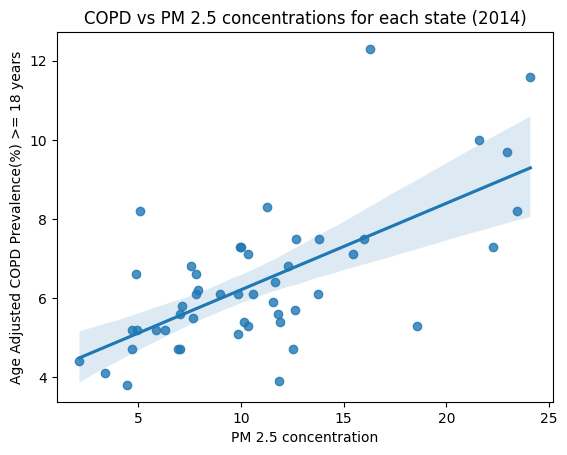

In [26]:
sns.regplot(data=copd_pm25,  x="01JUL2014", y="DataValue")
plt.xlabel("PM 2.5 concentration")
plt.ylabel("Age Adjusted COPD Prevalence(%) >= 18 years")
plt.title("COPD vs PM 2.5 concentrations for each state (2014)")
plt.savefig("figures/EDA1.png")

## Heatmaps of PM 2.5 concentrations at various times in the year

In [27]:
jan2014 = get_cdc_data("01JAN2014", ozone=False)
jan2014 = agg_county_weighted_mean(jan2014)

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
fig = px.choropleth(
    title=r"January 2014, PM 2.5 concentration",
    locations=jan2014['abbrev'],
    locationmode="USA-states",
    color=jan2014['01JAN2014'],
    scope="usa",
)
fig.layout.coloraxis.colorbar.title = "μg/m^3"
fig.show()

In [29]:
jul2014 = get_cdc_data("01JUL2014", ozone=False)
jul2014 = agg_county_weighted_mean(jul2014)

  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
fig = px.choropleth(
    title=r"July 2014, PM 2.5 concentration",
    locations=jan2014['abbrev'],
    locationmode="USA-states",
    color=jul2014['01JUL2014'],
    scope="usa",
)
fig.layout.coloraxis.colorbar.title = "μg/m^3"
fig.show()

## Scatterplot of Obesity Prevalence and Diabetes Prevalence

In [31]:
obesity = cdi[
    (cdi["Question"]=="Obesity among adults aged >= 18 years")
    & (cdi["DataValueType"] == "Age-adjusted Prevalence")
    & (cdi["StratificationCategory1"] == 'Overall')
].loc[:, ['YearStart', 'LocationAbbr', 'DataValueAlt']]

diabetes = cdi[
    (cdi["Question"]== "Prevalence of diagnosed diabetes among adults aged >= 18 years")
    & (cdi["DataValueType"]== "Age-adjusted Prevalence")
    & (cdi["StratificationCategory1"] == 'Overall')
].loc[:, ['YearStart', 'LocationAbbr', 'DataValueAlt']]

obesity_vs_diabetes = diabetes.merge(obesity, on=["YearStart", "LocationAbbr"], how="inner")
obesity_vs_diabetes.head()

,YearStart,LocationAbbr,DataValueAlt_x,DataValueAlt_y
0,2011,NV,10.0,24.3
1,2016,OH,9.7,31.4
2,2016,NE,8.1,32.1
3,2015,OR,9.6,30.1
4,2020,AL,13.1,39.3


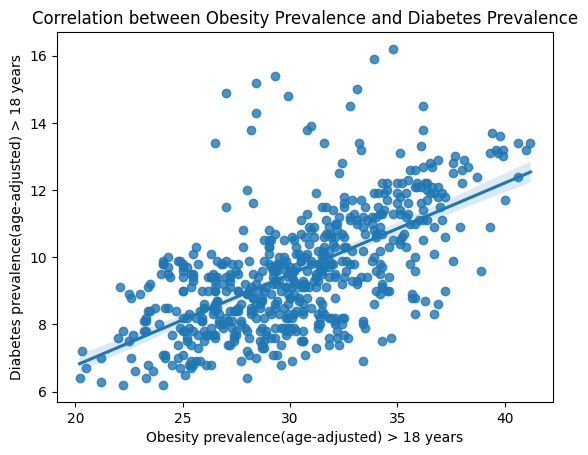

In [32]:
sns.regplot(data=obesity_vs_diabetes, y="DataValueAlt_x", x="DataValueAlt_y")
plt.xlabel("Obesity prevalence(age-adjusted) > 18 years")
plt.ylabel("Diabetes prevalence(age-adjusted) > 18 years")
plt.title("Correlation between Obesity Prevalence and Diabetes Prevalence")
plt.savefig("figures/EDA3.png")

## Percentage of Diagnosed Diabetes per Age Group (across 50 US States)

In [33]:
# drop unecessary columns
diabetes_age = categorical_diabetes.drop(columns=["male", "female", "State"])

# no data rows + drop guam, puerto rico - only 50 states
diabetes_age = diabetes_age.drop(index=[51, 52, 53, 54])

# convert to float
diabetes_age = diabetes_age.astype(float)
diabetes_age.head()

,18-44,45-64,65-74,75+
0,4.8,17.8,24.3,21.0
1,1.8,10.3,21.3,21.0
2,2.8,14.0,21.8,18.7
3,3.9,17.9,24.7,22.8
4,2.9,15.4,21.5,22.5


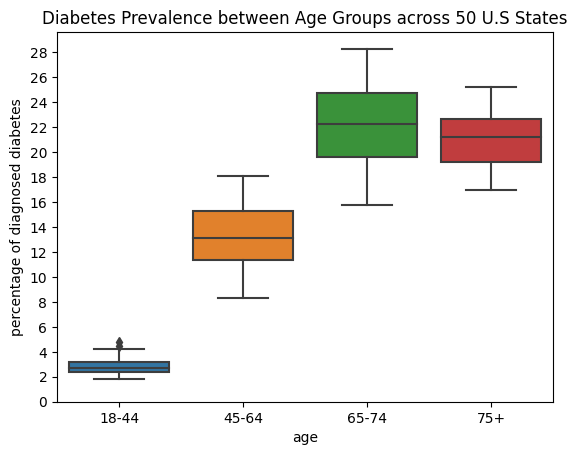

In [34]:
#plot Diabetes Prevalence per Age Group across 50 U.S States
sns.boxplot(x="variable", y="value", data=pd.melt(diabetes_age));
plt.title("Diabetes Prevalence between Age Groups across 50 U.S States");
plt.xlabel("age");
plt.ylabel("percentage of diagnosed diabetes");

plt.yticks(np.arange(0, 30, step=2))

plt.savefig("figures/EDA4.png");

## Diabetes Prevalence between Sex

In [35]:
diabetes_sex = categorical_diabetes[["male", "female"]]
diabetes_sex = diabetes_sex.iloc[:-2]
diabetes_sex = diabetes_sex.astype(float)
diabetes_sex.head()

,male,female
0,12.0,11.5
1,6.7,8.6
2,10.1,8.3
3,11.9,11.3
4,10.9,9.0


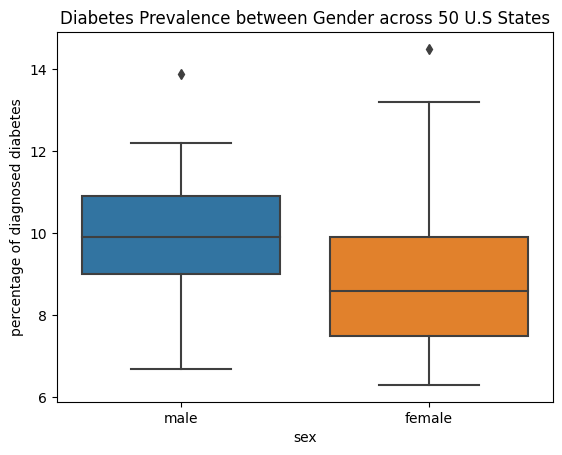

In [36]:
#plot Diabetes Prevalence per Age Group across 50 U.S States
sns.boxplot(x="variable", y="value", data=pd.melt(diabetes_sex));
plt.title("Diabetes Prevalence between Gender across 50 U.S States");
plt.xlabel("sex")
plt.ylabel("percentage of diagnosed diabetes")

plt.savefig("figures/EDA5.png");

# Research Question 1: Multiple Hypothesis Testing

**"Is there a significant association between diabetes and the following variables?"**

* Gender [categorical]
* Age [categorical]
* Soda consumption among high school students
* Obesity among adults aged >= 18 years
* Meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years
* Poverty Percentage
* Current lack of health insurance among adults aged 18-64 years
* Median daily frequency of fruit consumption among adults aged >= 18 years
* Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure
* Computer use among high school students
* Television viewing among high school students

In [37]:
dia_prev = cdi[(cdi['QuestionID'] == 'DIA2_1')
               & (cdi['YearStart'] == 2014)
               & (cdi['StratificationID1'] == 'OVR')
               & (cdi['DataValueTypeID'] == 'CRDPREV')]
dia_prev = dia_prev[["LocationAbbr", "DataValue"]]
dia_prev.columns = ['state', 'diabetes prevalence']
dia_prev = dia_prev.set_index('state')
dia_prev.head()

,diabetes prevalence
state,
AK,7.4
AL,12.9
AR,12.7
AZ,10.0
CA,10.3


In [38]:
# store p-values from every hypothesis test
pvals_df = pd.DataFrame({'hypothesis': pd.Series(dtype='str'),
                         'pvalue': pd.Series(dtype=np.float64)})

## Stratified data (difference in group means)

* Gender: z-test proportions, Male vs. Female
* Age: z-test between consolidated groups, 18-44 vs. 45+ (45-64, 65-74, 75+)
* Ethnicity/Race: z-test, White vs. Non-White

In [39]:
# Diabetes prevalence rates between sex and age groups
diabetes = categorical_diabetes.set_index("State")
diabetes = diabetes.replace("No Data", "NaN")
diabetes = diabetes.astype(float).dropna()
diabetes.head()

,male,female,18-44,45-64,65-74,75+
State,,,,,,
Alabama,12.0,11.5,4.8,17.8,24.3,21.0
Alaska,6.7,8.6,1.8,10.3,21.3,21.0
Arizona,10.1,8.3,2.8,14.0,21.8,18.7
Arkansas,11.9,11.3,3.9,17.9,24.7,22.8
California,10.9,9.0,2.9,15.4,21.5,22.5


In [40]:
# A/B Testing Code from HW1
def mean_calculation(dataset, binary_col, numerical_col):
    data = dataset[[binary_col, numerical_col]]
    means_table = data.groupby(binary_col).mean().reset_index()
    means = means_table.iloc[:,1]
    observed_mean = abs(means[1] - means[0])
    return observed_mean

def avg_difference_in_means(dataset, binary_col, numerical_col, weight_col=None, reps=25000):
    observed_difference = mean_calculation(dataset, binary_col, numerical_col)
    
    differences = []
    for _ in tqdm(range(reps)):
        dataset["shuffled"] = dataset[binary_col].sample(len(dataset), weights=dataset[weight_col]).values
        shuffled_df = dataset[["shuffled", numerical_col]]
        new_mean = mean_calculation(shuffled_df, "shuffled", numerical_col)
        differences.append(new_mean) 
        
    p_val = np.mean(differences >= observed_difference)
    return p_val

### Gender

In [41]:
state_pops_gender = pd.read_csv("data/state_pop_by_gender_2014.csv")
state_pops_gender = state_pops_gender.melt(id_vars="State")
state_pops_gender.columns = ['State', 'Gender', 'Population']

In [42]:
diabetes_gender = diabetes[["male", 'female']].reset_index()
diabetes_gender = pd.melt(diabetes_gender, id_vars='State', value_vars=["male", 'female'],
                          var_name='Gender', value_name='Prevalence')
diabetes_gender = diabetes_gender.merge(state_pops_gender, left_on=["State", "Gender"], right_on=["State", "Gender"], how='left').dropna()
diabetes_gender.head()

,State,Gender,Prevalence,Population
0,Alabama,male,12.0,2335261.0
1,Alaska,male,6.7,366924.0
2,Arizona,male,10.1,3330681.0
3,Arkansas,male,11.9,1452141.0
4,California,male,10.9,19033322.0


In [43]:
pval = avg_difference_in_means(diabetes_gender, 'Gender', 'Prevalence', weight_col="Population")
pvals_df.loc[len(pvals_df), :] = ['gender', pval]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [44]:
print("p value:", pval)

p value: 0.00012


### Age Groups

ANOVA doesn't work with proportions, so we can just consolidate young (18-44) vs old (45+)

In [45]:
pop_age = pd.read_csv("data/state_pop_by_age_group_2014.csv", index_col="State").dropna().astype(int)
pop_age['45+'] = pop_age.iloc[:, 1:4].sum(axis=1)

# Use 45+ population distribution to find consolidated prevalence
diabetes_age = diabetes.iloc[:, 2:]
diabetes_age.loc[:, '45+'] = (diabetes_age.iloc[:, 1:4] * pop_age.iloc[:, 1:4]).sum(axis=1) / pop_age['45+']
diabetes_age = diabetes_age[["18-44", "45+"]].reset_index()

<ipython-input-45-fe5ae9bb9c8e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
pop_age_melt = pop_age[["18-44", "45+"]].reset_index().melt(id_vars="State")
pop_age_melt.columns = ['State', 'Age', 'Population']

diabetes_age = pd.melt(diabetes_age, id_vars='State', value_vars=["18-44", "45+"],
                          var_name='Age', value_name='Prevalence')
diabetes_age = diabetes_age.merge(pop_age_melt, left_on=["State", "Age"], right_on=["State", "Age"], how='left').dropna()
diabetes_age.head()

,State,Age,Prevalence,Population
0,Alabama,18-44,4.8,1696835.0
1,Alaska,18-44,1.8,265580.0
2,Arizona,18-44,2.8,2401117.0
3,Arkansas,18-44,3.9,1034925.0
4,California,18-44,2.9,14674439.0


In [47]:
pval = avg_difference_in_means(diabetes_age, 'Age', 'Prevalence', weight_col="Population")
pvals_df.loc[len(pvals_df), :] = ['age', pval]
print("p value:", pval)

  0%|          | 0/25000 [00:00<?, ?it/s]

p value: 0.0


## Correlation Tests

### Helper Functions

In [48]:
def question_lookup(question):
  query_res = cdi[cdi['Question'].str.contains(question, flags=re.IGNORECASE)]
  matches = query_res['QuestionID'].unique()
  if len(matches) > 1:
    return [(a, b) for a,b in zip(query_res['Question'].unique(), matches)]
  elif len(matches) == 0:
    print("No questions found.")
    return None

  print("found", query_res['Question'].unique())
  return matches[0]

In [49]:
def correlation_test(x, y, weight=None):
  """
  Calculates p-value for either OLS or WLS for y = mx + const.
    (does WLS if weight is not None, otherwise OLS)

  X, Y, and WEIGHT should be pandas series (or 1-column DataFrames)
    with the state 2-letter abbreviations as indexes.
  """
  weighted = weight is not None
  X = sm.add_constant(x)

  if weighted:
    model = sm.WLS(y, X, weights=weight)
  else:
    model = sm.OLS(y, X)
  
  results = model.fit()
  pvals = results.pvalues

  return pvals[-1], results.params

In [50]:
def correlation_test_helper(cdi_QuestionID,
                            subset='adult',
                            year=2014,
                            StratificationID1='OVR',
                            DataValueTypeID='CRDPREV',
                            plot=False,
                            reg=['ols', 'wls']):

  xdata = cdi[cdi['QuestionID'] == cdi_QuestionID]

  if StratificationID1 not in xdata['StratificationID1'].unique():
    print("StratificationID1 must be one of", xdata['StratificationID1'].unique())
    return
  elif DataValueTypeID not in xdata['DataValueTypeID'].unique():
    print("DataValueTypeID must be one of", xdata['DataValueTypeID'].unique())
    return
  elif year not in xdata['YearStart'].unique():
    print("Year must be one of", xdata['YearStart'].unique())
    return

  xdata = xdata[
      (xdata['StratificationID1'] == StratificationID1)
      & (xdata['DataValueTypeID'] == DataValueTypeID)
      & (xdata['YearStart'] == year)]
  xdata = xdata[["LocationAbbr", "DataValue"]]
  xdata = xdata.set_index('LocationAbbr')

  # load population data for weight
  if subset == 'adult':
    weight = pd.read_csv("data/adult_pop_2014.csv", index_col=0)
    weight = weight.set_index('Postal')['adult population']
  elif subset == 'hs':
    weight = pd.read_csv("data/hs_aged_pop_2013.csv", index_col=0)
    weight = weight.set_index('Postal')['num HS age']
  else:
    weight=None

  # join data and drop missing data
  if weight is not None:
    df = xdata.join([dia_prev, weight], how="inner").astype(float).dropna()
  else:
    df = xdata.join(dia_prev, how="inner").astype(float).dropna()
    w=None

  if len(df) <= 1:
    print("Not enough data for regression.")
    return
  
  print(f"regressing on {len(df)} samples")
  
  x = df.iloc[:, 0]
  y = df.iloc[:, 1]

  if 'ols' in reg:
    pval_ols, coeffs_ols = correlation_test(x, y)
  if 'wls' in reg:
    w = df.iloc[:, 2]
    pval_wls, coeffs_wls = correlation_test(x, y, w)

  if plot:
    sns.scatterplot(x=x, y=y, size=w, legend=None)

    xx = np.array([x.min(), x.max()])
    if 'wls' in reg:
      b, m = coeffs_wls
      plt.plot(xx, b + m*xx, c='green', label="WLS line (pval=" + str(round(pval_wls, 15)) + ")")
    
    if 'ols' in reg:
      b, m = coeffs_ols
      plt.plot(xx, b + m*xx, c='red', label="OLS line (pval=" + str(round(pval_ols, 15)) + ")")

    plt.legend()
  
  pvals = {}
  if 'wls' in reg: pvals['wls'] = pval_wls
  if 'ols' in reg: pvals['ols'] = pval_ols
  return pvals

### Soda consumption among high school students

Question ID: NPAW12_2

regressing on 38 samples


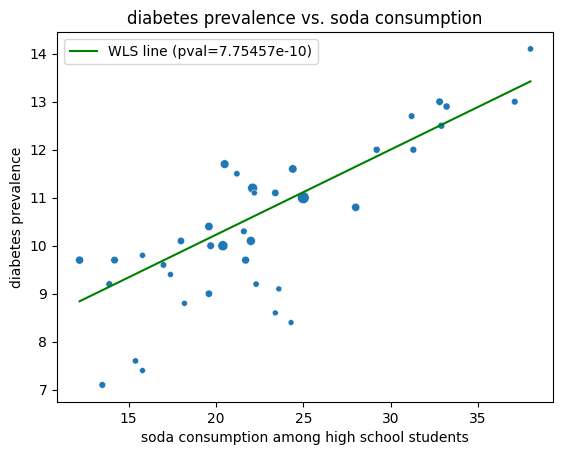

In [51]:
soda = correlation_test_helper('NPAW12_2', 'hs', 2013, plot=True, reg='wls')
plt.xlabel("soda consumption among high school students")
plt.title("diabetes prevalence vs. soda consumption")
plt.savefig("figures/soda_diabetes.png")

In [52]:
pvals_df.loc[len(pvals_df), :] = ['soda consumption', soda['wls']]

### Obesity among adults aged >= 18 years

Question ID: NPAW1_1

regressing on 51 samples


{'wls': 3.7872355712106028e-06}

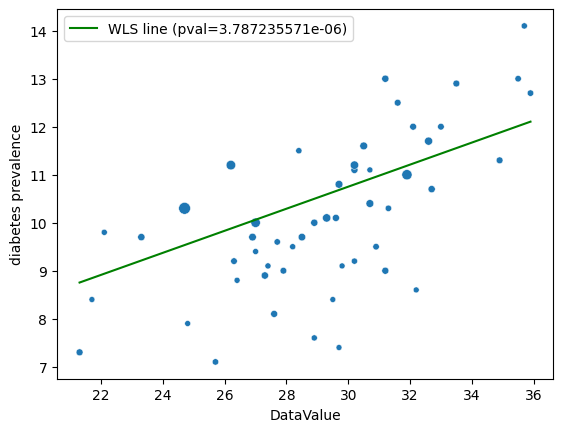

In [53]:
obesity = correlation_test_helper('NPAW1_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['obesity', obesity['wls']]
obesity

### Overweight or obesity among adults aged >= 18 years

Question ID: NPAW2_1

In [54]:
overweight_obesity = correlation_test_helper('NPAW2_1', 'adult', 2014, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['overweight or obesity', overweight_obesity['wls']]
overweight_obesity

regressing on 51 samples


{'wls': 3.736049286113199e-05}

### Meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years

Question ID: NPAW11_1

regressing on 51 samples


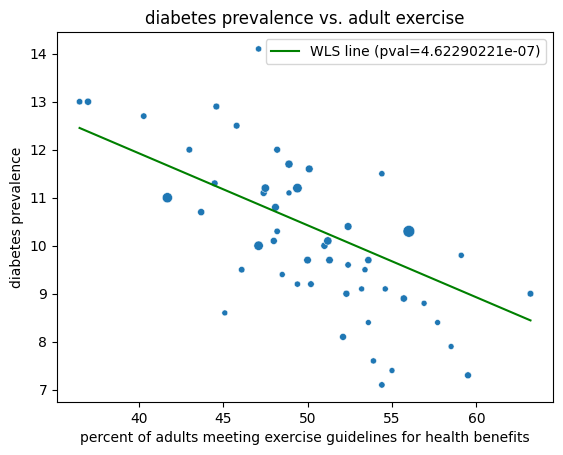

In [55]:
activity = correlation_test_helper('NPAW11_1', 'adult', 2013, plot=True, reg='wls')
plt.xlabel("percent of adults meeting exercise guidelines for health benefits")
plt.title("diabetes prevalence vs. adult exercise")
plt.savefig("figures/exercise_diabetes.png")

In [56]:
pvals_df.loc[len(pvals_df), :] = ['physical activity', activity['wls']]

### Poverty Percentage

Question ID: OVC3_1

regressing on 51 samples


{'wls': 1.8873477812033962e-08}

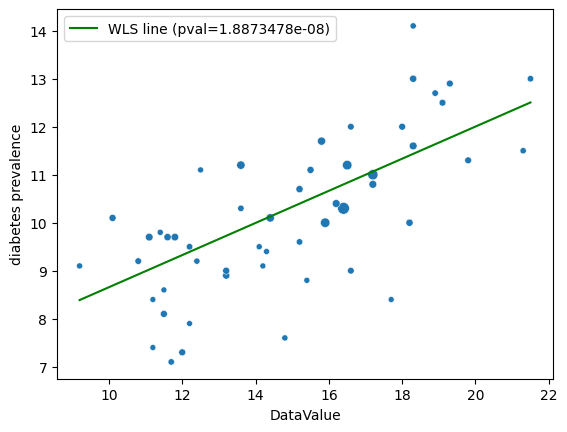

In [57]:
poverty = correlation_test_helper('OVC3_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['poverty percentage', poverty['wls']]
poverty

### Current lack of health insurance among adults aged 18-64 years

Question ID: OVC1_1

regressing on 51 samples


{'wls': 0.0057529276462077025}

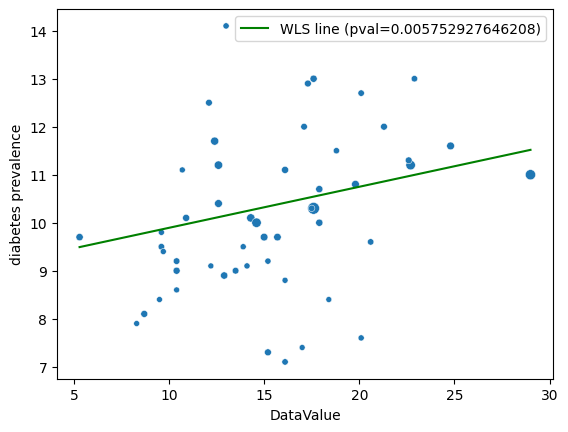

In [58]:
insurance = correlation_test_helper('OVC1_1', 'adult', 2014, plot=True, reg="wls")
pvals_df.loc[len(pvals_df), :] = ['lack of health insurance', insurance['wls']]
insurance

### Median daily frequency of fruit consumption among adults aged >= 18 years

Question ID: OVC1_1

In [59]:
question_lookup("fruit consumption among adults")

found ['Median daily frequency of fruit consumption among adults aged >= 18 years']


'NPAW4_2'

regressing on 51 samples


{'wls': 0.07527940134586408}

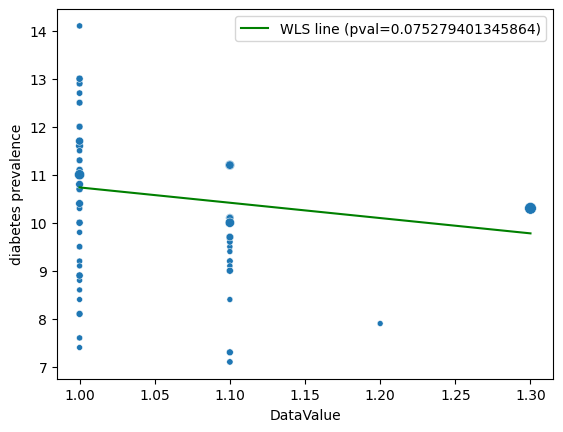

In [60]:
fruit = correlation_test_helper('NPAW4_2', 'adult', 2013, reg="wls", DataValueTypeID='MEDIAN', plot=True)
pvals_df.loc[len(pvals_df), :] = ['fruit consumption', fruit['wls']]
fruit

### Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure

In [61]:
question_lookup("blood pressure")

[('Awareness of high blood pressure among women aged 18-44 years', 'CVD6_2'),
 ('Awareness of high blood pressure among adults aged >= 18 years', 'CVD6_1'),
 ('Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
  'DIA11_2'),
 ('Taking medicine for high blood pressure control among adults aged >= 18 years with high blood pressure',
  'CVD7_0')]

regressing on 51 samples


{'wls': 1.9131224434304085e-06}

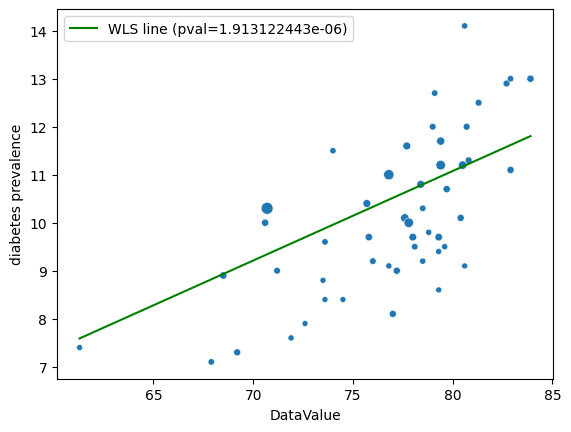

In [62]:
bp = correlation_test_helper('CVD7_0', 'adult', 2013, reg="wls", plot=True)
pvals_df.loc[len(pvals_df), :] = ['taking medicine for high blood pressure', bp['wls']]
bp

### Computer use among high school students

In [63]:
question_lookup("computer")

found ['Computer use among high school students']


'NPAW21_0'

regressing on 40 samples


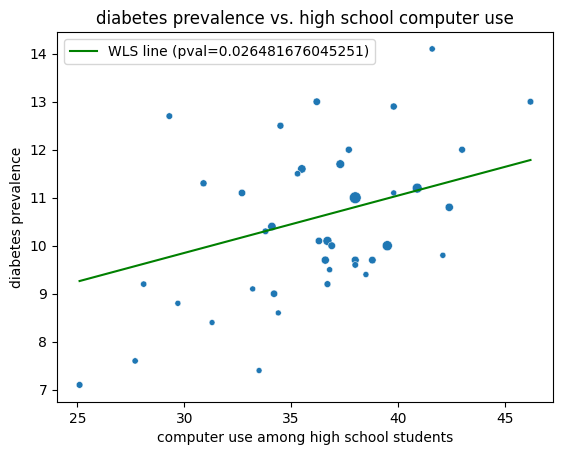

In [64]:
computer = correlation_test_helper('NPAW21_0', 'hs', 2013, reg="wls", plot=True)
plt.xlabel("computer use among high school students")
plt.title("diabetes prevalence vs. high school computer use")
plt.savefig("figures/computer_diabetes.png")

In [65]:
pvals_df.loc[len(pvals_df), :] = ['computer use', computer['wls']]

### Television viewing among high school students

In [66]:
question_lookup("television")

found ['Television viewing among high school students']


'NPAW20_0'

regressing on 40 samples


{'wls': 1.962193805660829e-08}

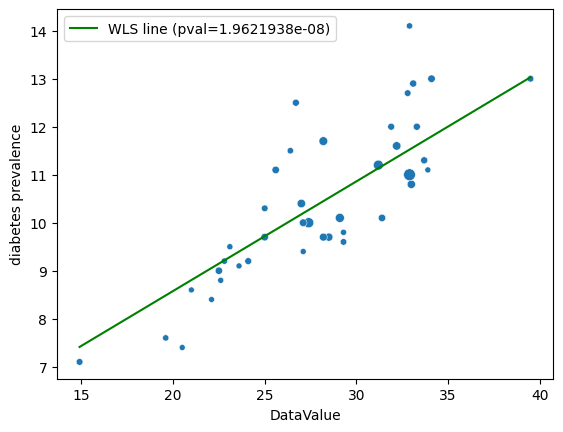

In [67]:
tv = correlation_test_helper('NPAW20_0', 'hs', 2013, reg="wls", plot=True)
pvals_df.loc[len(pvals_df), :] = ['television use', tv['wls']]
tv

## Controlling Error rates

In [68]:
pvals_df = pvals_df.sort_values(by='pvalue')[['hypothesis', 'pvalue']]
pvals_df

,hypothesis,pvalue
1,age,0.000000e+00
2,soda consumption,7.754571e-10
6,poverty percentage,1.887348e-08
11,television use,1.962194e-08
5,physical activity,4.622902e-07
9,taking medicine for high blood pressure,1.913122e-06
3,obesity,3.787236e-06
4,overweight or obesity,3.736049e-05
0,gender,1.200000e-04
7,lack of health insurance,5.752928e-03


In [69]:
# Naive
pvals_df["No control"] = (pvals_df['pvalue'] <= 0.05)

In [70]:
# B-Y Correction
import statsmodels.stats
pvals_df["B-Y"] = statsmodels.stats.multitest.fdrcorrection(pvals_df['pvalue'],
                                                            alpha=0.05,
                                                            method='n',
                                                            is_sorted=True)[0]

In [71]:
# Bonferroni Correction 
m = len(pvals_df)
alpha = 0.05
bonf_threshold = alpha/m
pvals_df["Bonferroni"] = (pvals_df['pvalue'] <= bonf_threshold)

In [72]:
pvals_df

,hypothesis,pvalue,No control,B-Y,Bonferroni
1,age,0.000000e+00,True,True,True
2,soda consumption,7.754571e-10,True,True,True
6,poverty percentage,1.887348e-08,True,True,True
11,television use,1.962194e-08,True,True,True
5,physical activity,4.622902e-07,True,True,True
9,taking medicine for high blood pressure,1.913122e-06,True,True,True
3,obesity,3.787236e-06,True,True,True
4,overweight or obesity,3.736049e-05,True,True,True
0,gender,1.200000e-04,True,True,True
7,lack of health insurance,5.752928e-03,True,True,False


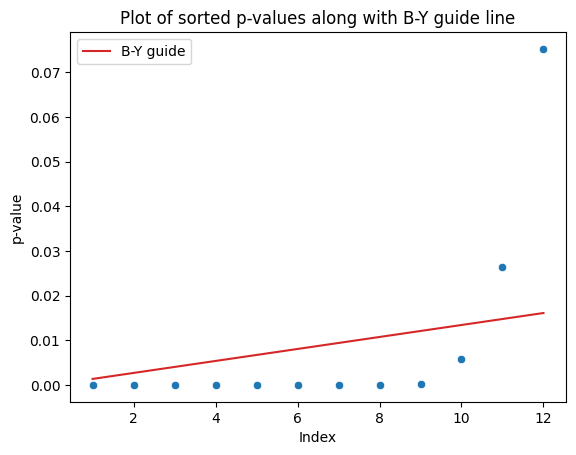

In [73]:
index = np.arange(1, m+1)
cm = np.sum(1 / np.arange(1, m+1))

sns.scatterplot(x=index, y=pvals_df['pvalue'])
plt.plot(index, index/(m*cm) * alpha, label='B-Y guide', color='tab:red')

plt.title("Plot of sorted p-values along with B-Y guide line")
plt.xlabel("Index")
plt.ylabel("p-value")
plt.legend()

plt.savefig("figures/BY.png")

# Research Question 2: Causal Inference

**Research Question:**

Causal effect of Pm2.5 concentration on COPD (chronic obstructive pulmonary disease)

*resources:*

https://towardsdatascience.com/causal-inference-with-continuous-treatments-5ff691869a65 

difference in outcomes - lab 8

https://www.practicalpropensityscore.com/continuous.html




## Preparing COPD and smoking datasets

In [74]:
copd = cdi[(cdi['Topic'] == "Chronic Obstructive Pulmonary Disease") &
           (cdi['Question'] == 'Prevalence of chronic obstructive pulmonary disease among adults >= 18') &
           (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]

copd = copd[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "COPD Prevalence"})

In [75]:
smoking = cdi[(cdi["Topic"] == 'Tobacco') & (cdi["Question"] == "Current smoking among adults aged >= 18 years") &
              (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]

smoking = smoking[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "Smoking Prevalence"})

In [76]:
yearly_pm25_avg = pd.read_csv("data/yearly_pm_by_state.csv")
yearly_pm25_avg = yearly_pm25_avg.melt(id_vars='abbrev').rename(columns={'variable': 'YEAR', 'value': 'pm25'})
yearly_pm25_avg.head()

,abbrev,YEAR,pm25
0,AL,2011,11.748242
1,AZ,2011,7.838444
2,AR,2011,11.059018
3,CA,2011,9.746000
4,CO,2011,5.870499


In [77]:
copd["YearStart"] = copd["YearStart"].astype(str)
smoking["YearStart"] = smoking["YearStart"].astype(str)
yearly_pm25_avg["YEAR"] = yearly_pm25_avg["YEAR"].astype(str)

## Merging CDI and PM2.5 datasets

In [78]:
data = yearly_pm25_avg.merge(smoking, left_on=["YEAR", "abbrev"], right_on=['YearStart', 'LocationAbbr'], how='inner')
data = data[["YEAR", "abbrev", "pm25", "Smoking Prevalence"]]

In [79]:
df = copd.merge(data, left_on=["LocationAbbr", "YearStart"], right_on=["abbrev", "YEAR"], how='inner')
df.head()

,YearStart,LocationAbbr,LocationDesc,COPD Prevalence,LowConfidenceLimit,HighConfidenceLimit,YEAR,abbrev,pm25,Smoking Prevalence
0,2011,AL,Alabama,9.3,8.4,10.2,2011,AL,11.748242,24.6
1,2013,AL,Alabama,9.9,8.9,11.0,2013,AL,9.714757,22.1
2,2012,AL,Alabama,9.3,8.5,10.2,2012,AL,11.454434,24.4
3,2014,AL,Alabama,9.7,8.9,10.5,2014,AL,12.506239,21.7
4,2012,AR,Arkansas,8.2,7.4,9.2,2012,AR,9.843660,25.7


In [80]:
data_filtered = df[["YEAR", "abbrev", "pm25", "Smoking Prevalence", "COPD Prevalence"]]
data_filtered = data_filtered.rename(columns={'Smoking Prevalence':"smoking_prevalence", "COPD Prevalence": "copd_prevalence"})
data_filtered.sort_values(by='pm25').head()

,YEAR,abbrev,pm25,smoking_prevalence,copd_prevalence
195,2014,WY,4.797520,19.9,6.4
97,2013,MT,4.929152,19.6,5.9
193,2013,WY,5.199149,20.8,6.7
104,2014,ND,5.200405,20.6,4.4
182,2012,WA,5.418286,17.2,5.5


## Outcome regression with IPW

In [81]:
def conditional_densities(data, use_confounders=True):
    formula = "pm25 ~ 1"
    if use_confounders:
        formula += "+ smoking_prevalence"
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm(
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )
    densities = density.pdf(data["pm25"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities

In [82]:
denominator = conditional_densities(data_filtered, use_confounders=True)
numerator = conditional_densities(data_filtered, use_confounders=False)
generalized_ipw = numerator / denominator

In [83]:
generalized_ipw

0      0.729269
1      0.954873
2      0.764066
3      0.893179
4      0.953540
         ...   
191    0.916872
192    1.652012
193    1.242220
194    1.423198
195    1.110807
Length: 196, dtype: float64

In [84]:
model_copd = sm.formula.wls(
    "copd_prevalence ~ 1 + pm25 ",
    data=data_filtered,
    weights=generalized_ipw,
).fit()

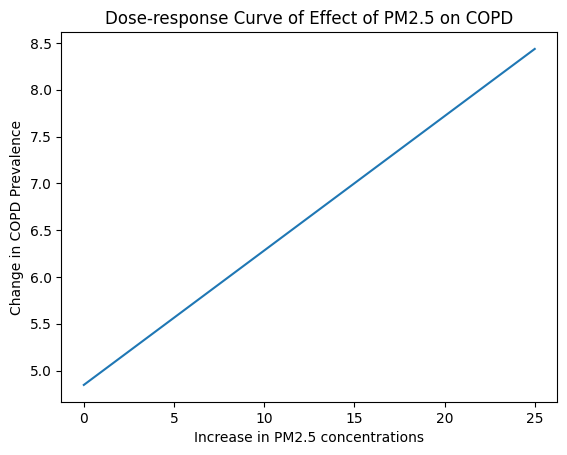

In [85]:
concentration = list(range(26))
concentration = pd.DataFrame(
    data={"pm25": concentration},
    index=concentration)
response = model_copd.predict(concentration)
ax = response.plot(
    kind="line",
    xlabel="Increase in PM2.5 concentrations",
    ylabel="Change in COPD Prevalence",
    title="Dose-response Curve of Effect of PM2.5 on COPD"
)

In [86]:
model_copd.conf_int()

,0,1
Intercept,3.827262,5.865089
pm25,0.037483,0.249698


In [87]:
model_copd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        copd_prevalence   R-squared:                       0.035
Model:                            WLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     7.123
Date:                Mon, 08 May 2023   Prob (F-statistic):            0.00825
Time:                        21:08:26   Log-Likelihood:                -356.43
No. Observations:                 196   AIC:                             716.9
Df Residuals:                     194   BIC:                             723.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8462      0.517      9.381      0.000       3.827       5.865
pm25           0.1436      0.054      2.669      0.008       0.037       0.250
==============================================================================
Omnibus:                       29.642   Durbin-Watson:                   1.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.991
Skew:                           0.890   Prob(JB):                     7.62e-10
Kurtosis:                       4.406   Cond. No.                         47.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""